### Imports

In [1]:
import sys
sys.path.append('../popalign/')
import popalign as PA
import importlib

In [2]:
PA.__file__

'../popalign/popalign.py'

### Load data
Run the first cell if samples are stored individually  
Run the second cell if samples are stored in the same matrix (requires meta data file)

In [ ]:
# Load samples from distinct matrix files
mysamples = {
    'CTRL' : '../data/samples/PBMC.mtx',
    'GMCSF_1ng/ml' : '../data/samples/GMCSF.mtx',
    'IFNG_1ng/ml' : '../data/samples/IFNG.mtx',
    'IL2_10ng/ml' : '../data/samples/IL2.mtx',
    'CD40L_20ng/ml' : '../data/samples/CD40L.mtx',
}
mygenes = '../data/samples/genes.tsv'

pop = PA.load_samples(samples=mysamples, 
                      genes=mygenes,
                      outputfolder='output_samples')

In [14]:
# Load samples from one matrix file with metadata
# (must include cell_barcode, sample_id columns)
mymatrix = '../data/screen/PBMC-MULT-8/matrix.mtx'
mybarcodes = '../data/screen/PBMC-MULT-8/barcodes.tsv'
mygenes = '../data/screen/PBMC-MULT-8/features.csv'
mymetadata = '../data/screen/PBMC-MULT-8/updated_meta.csv'

pop = PA.load_multiplexed(matrix=mymatrix, 
                     barcodes=mybarcodes, 
                     metafile=mymetadata, 
                     genes=mygenes,
                     outputfolder='output_multiplexed_pbmc8_nocd3',
                     only=[], # list of sample names to only load the specified samples
                     col='CD3', # either None or a column name from the meta data
                     value=0) # if col != None, specify value in column to filter samples

In [15]:
PA.print_ncells_ncells(pop)

CONTROL 	 8380
Apocynin 	 1187
Fostamatinib (R788) 	 1320
Clobetasol propionate 	 1018
Cortisone acetate 	 1084
Olopatadine HCl 	 961
Dimethyl Fumarate 	 1127
BMS-378806 	 1069
Brompheniramine hydrogen maleate 	 1023
Zaltoprofen 	 1232
Lumiracoxib 	 1230
JNJ-7777120 	 1242
Neohesperidin 	 1060
Asaraldehyde 	 1010
Camostat Mesilate 	 1344
Prednisolone Acetate 	 1169
Acemetacin 	 1118
Tangeretin 	 1074
Rutin 	 1011
Bufexamac 	 1249
Phenacetin 	 1041
WZ811 	 1096
Tempol 	 1304
Alogliptin（SYK-322）benzoate 	 1229
Idebenone 	 1248
Salicin 	 1094
Tenoxicam 	 983
Tofacitinib (CP-690550_Tasocitinib) 	 1061
Niflumic acid 	 1316
Rutaecarpine 	 1100
Pyrantel Pamoate 	 1070
Hesperetin 	 1209
Acetanilide 	 766
Dihydromyricetin 	 1236
Aspirin 	 1156
Fluocinonide 	 1085
Laquinimod 	 1166
Pirfenidone 	 1067
Azelastine HCl 	 1236
Geniposidic acid 	 961
Ciproxifan Maleate 	 1128
Total number of cells loaded: 53460


### Normalize and gene filter

In [16]:
# Perform column normalization
# Find best normalization factor
'''
Parameters
----------
scaling factor: Number used to scale the data values. If None, that factor is computed automatically.
ncells: Number of cells to randomly subsample to try different normalization factors to use less memory. If None, all cells are used.
'''
PA.normalize(pop, scaling_factor=None, ncells=None)

Performing column normalization
Finding best scaling factor


1567 genes selected


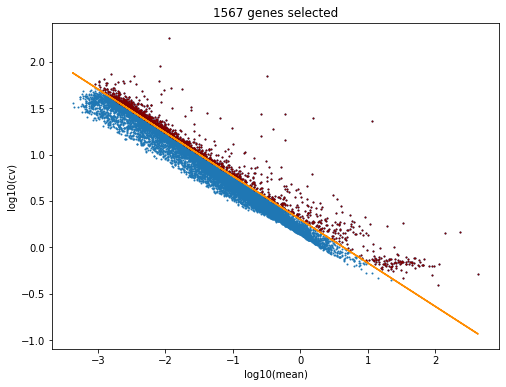

In [17]:
# Plot genes (log cv ~ log cv) and filtering line --use multiple times to find best offset (usually between .7 and 1.5)
'''
Parameters
----------
offset: Value (its log) will be added to the intercept of the linear fit to filter genes
'''
PA.plot_gene_filter(pop, offset=1.2)

In [18]:
# Gene filter the data with the last offset value used in the previous step
'''
Parameters
----------
remove_ribosomal: remove genes that start with RPS or RPL if True
'''
PA.filter(pop, remove_ribsomal=True)

Removing ribosomal genes
Filtering genes ang logging data


In [ ]:
# Remove red blood cells from the data
PA.removeRBC(pop, species='human')

### Dimensionality reduction

In [19]:
# Generate multiple feature spaces and pick the best one based on reconstruction error
# Run GSEA on each feature
# Generate QC plots
'''
Parameters
----------
ncells: Number of cells to randomly sample
nfeats: Number or list of numbers of features to use
nreps: Number of repetitions to perform for each k in nfeats
niter: Maximum number of iterations to perform for each instance of the algoirthm
'''
importlib.reload(PA)
PA.onmf(pop, ncells=5000, nfeats=[5,7], nreps=3, niter=500)

Computing W matrices
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #499
......... Iteration #499
Orthogonal NMF performed with 500 iterations

......... Iteration #499
Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

......... Iteration #499
...

### Build probabilistic models

In [20]:
# Build a Gaussian Mixture model for each sample
# Type the models subpopulations
'''
Parameters
----------
ks: Number or range (tuple) of components to use
niters: number of replicates to build for each k in `ks`
training: If training is float, the value will be used a percentage to select cells for the training set. Must follow 0<value<1
          If training is int, that number of cells will be used for the training set.
nreplicates: Number of model replicates to generate for each sample. These replicates model will be used to provide confidence intervals later in the analysis.
rendering: One of grouped, individual or unique
types: Dictionary of cell type markers, 'defaultpbmc' or None
figsizegrouped: Size of the figure for the renderings together. Default is (20,20)
figsizesingle: Size of the figure for each single sample rendering. Default is (5,5)
'''
importlib.reload(PA)
PA.build_gmms(pop, 
              ks=(4,8), 
              niters=2, 
              training=.8, 
              nreplicates=2,
              reg_covar='auto', 
              rendering='grouped', 
              types='defaultpbmc', # either None, 'defaultpbmc' or a dictionary
              figsizegrouped=(20,20),
              figsizesingle=(6,5))

Building model for CONTROL (1 of 41)
Building model for Apocynin (2 of 41)
Building model for Fostamatinib (R788) (3 of 41)
Building model for Clobetasol propionate (4 of 41)
Building model for Cortisone acetate (5 of 41)
Building model for Olopatadine HCl (6 of 41)
Building model for Dimethyl Fumarate (7 of 41)
Building model for BMS-378806 (8 of 41)
Building model for Brompheniramine hydrogen maleate (9 of 41)
Building model for Zaltoprofen (10 of 41)
Building model for Lumiracoxib (11 of 41)
Building model for JNJ-7777120 (12 of 41)
Building model for Neohesperidin (13 of 41)
Building model for Asaraldehyde (14 of 41)
Building model for Camostat Mesilate (15 of 41)
Building model for Prednisolone Acetate (16 of 41)
Building model for Acemetacin (17 of 41)
Building model for Tangeretin (18 of 41)
Building model for Rutin (19 of 41)
Building model for Bufexamac (20 of 41)
Building model for Phenacetin (21 of 41)
Building model for WZ811 (22 of 41)
Building model for Tempol (23 of 41)


In [ ]:
# If the renderings do not have the right figure size, regenerate the renderings with:
#PA.render_models(pop, figsizegrouped=(20,20), figsizesingle=(6,5), mode='grouped')

### Align subpopulations

In [21]:
# Align subpopulations of each sample against a reference model's subpopulations
'''
Parameters
----------
ref: Name of reference sample
method: Method to perform the alignment
    If 'conservative', the reference component and the test component have to be each other's best match to align
    If 'aligntest', the closest reference component is found for each test component
    If 'alignref', the closest test component is found for each test component
figsizedeltas: Size of the figure for the delta plot. Default is (10,5)
figsizeentropy: Size of the figure for the entropy plot. Default is (10,5)
'''
PA.align(pop, ref='CONTROL',
         method='conservative',
         figsizedeltas=(10,10),
         figsizeentropy=(10,10))

In [50]:
# Get list of differentially expressed genes between a reference subpopulation
# and a sample's subpopulation that aligned to it
refcomp = 1
sample = 'Clobetasol propionate'
importlib.reload(PA)
genelist = PA.diffexp(pop,
                      refcomp=refcomp,
                      sample=sample,
                      nbins=20, 
                      cutoff=1,
                      renderhists=False,
                      usefiltered=False)

172.0185408592224
32738


In [ ]:
importlib.reload(PA)
PA.plot_heatmap(pop,
                refcomp=refcomp,
                genelist=genelist,
                cluster=True, 
                savename='%d_%s' % (refcomp,sample) ,# either None or a string
                figsize=(20,20),
                cmap='Purples',
                samplelimits=False,
                scalegenes=True,
                only=None)

### Visualize genes in subpopulations

In [ ]:
importlib.reload(PA)
PA.plot_genes_gmm_cells(pop,
               sample='unique',
               genelist=genelist,
               savename='',
               metric='correlation',
               method='single',
               clustergenes=False,
               clustercells=False,
               cmap='magma',
               figsize=(15,15)
)

### Rank samples

In [ ]:
# Rank each sample against a reference sample's model
importlib.reload(PA)
PA.rank(pop,
        ref='CTRL', # label of the reference sample
        k=100, # number of cells to randomly sample from sample
        niter=200, # number of iterations
        method='LLR', # LLR for log-likelihood ratio or LL for log-likelihood
        mincells=50, # sample's minimum number of cells to be ranked
        figsize=(10,5)) # plot figure size

### Build unique GMM for all samples

In [ ]:
# Build a unique GMM for the samples concatenated together
importlib.reload(PA)
PA.build_unique_gmm(pop, 
                    ks=(5,20), 
                    niters=3, 
                    training=0.2, 
                    reg_covar=True, 
                    types='defaultpbmc', # either None, 'defaultpbmc' or a dictionary
                    figsize=(6,5))

In [ ]:
# Generate a query plot
PA.plot_query(pop,  pcells=.2, nreps=10, figsize=(5,20), sharey=True)

### 2D visualization

In [ ]:
importlib.reload(PA)
PA.scatter(pop, method='umap', color='CD3D')
PA.scatter(pop, method='umap', color='LYZ')
PA.scatter(pop, method='tsne', color='CD3D')
PA.scatter(pop, method='tsne', color='LYZ')

### 3D visualization

In [ ]:
# Interactive 3D visualization of the data in feature space
importlib.reload(PA)
import plotly
plotly.offline.init_notebook_mode()
PA.plotfeatures(pop)

### Work in progress

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#-------------- WORK IN PROGRESS BELOW ----------------
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [31]:
pop['samples']['CONTROL']['M_norm']

<1496x8380 sparse matrix of type '<class 'numpy.float64'>'
	with 1113779 stored elements in Compressed Sparse Column format>